tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


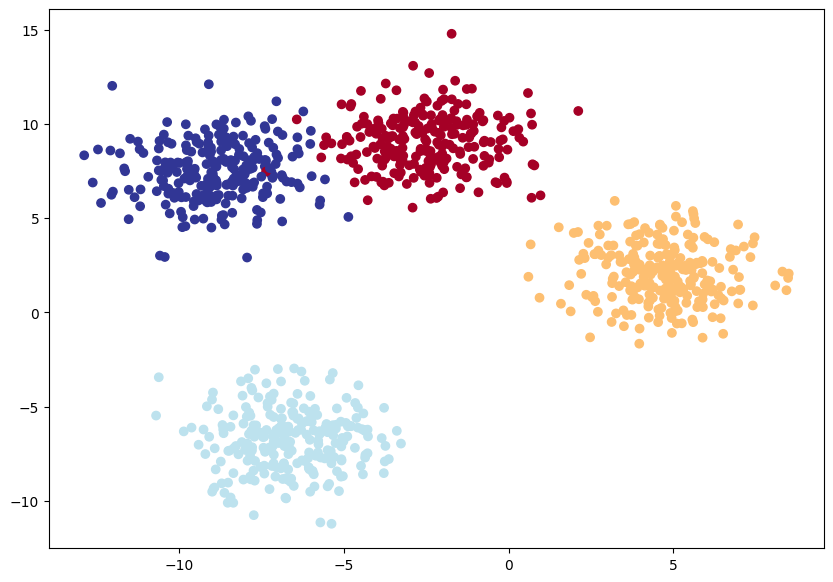

In [578]:
# Import dependencies
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [579]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [580]:
# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [581]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), 
                            lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

In [582]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test.to(device))
    # test_pred_prob = torch.softmax(test_logits, dim=1)
y_logits[:10]

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852],
        [ 2.0878, -1.3728,  2.1248,  2.5052],
        [ 1.8310,  0.8851,  2.1674,  0.6006],
        [ 0.1412, -1.4742, -0.0360,  1.0373],
        [ 2.9426,  0.7047,  3.3670,  1.6184],
        [-0.0645, -1.5006, -0.2666,  0.8940]], device='cuda:0')

In [583]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [584]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_logits[:5], y_pred_probs[:5]

(tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
         [ 1.7168, -1.2270,  1.7367,  2.1010],
         [ 2.2400,  0.7714,  2.6020,  1.0107],
         [-0.7993, -0.3723, -0.9138, -0.5388],
         [-0.4332, -1.6117, -0.6891,  0.6852]], device='cuda:0'),
 tensor([[0.1872, 0.2918, 0.1495, 0.3715],
         [0.2824, 0.0149, 0.2881, 0.4147],
         [0.3380, 0.0778, 0.4854, 0.0989],
         [0.2118, 0.3246, 0.1889, 0.2748],
         [0.1945, 0.0598, 0.1506, 0.5951]], device='cuda:0'))

In [585]:
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([3, 3, 2, 1, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2,
        2, 2, 3, 3, 3, 3, 3, 1, 1, 2, 1, 2, 1, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3,
        3, 3, 1, 3, 3, 1, 3, 2, 3, 1, 3, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 3, 3, 2, 3, 3, 3, 3, 2, 3, 1, 3, 3, 2, 1, 1, 3, 2, 2, 3, 3, 3, 1, 2,
        2, 3, 3, 1, 2, 3, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 1, 1, 3, 2, 2,
        2, 2, 3, 3, 3, 2, 2, 1, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3,
        2, 2, 2, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 2, 2, 3, 2, 2, 3, 3, 2, 2, 3, 3,
        1, 3, 2, 3, 3, 1, 2, 3], device='cuda:0')

In [586]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [587]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    model_4.train()
    y_logits = model_4(X_blob_train)
    y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_preds)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_preds)

        if epoch % (epochs / 10) == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 1.04324, Accuracy: 65.50% | Test loss: 0.57861, Test acc: 95.50%
Epoch: 10 | Loss: 0.14398, Accuracy: 99.12% | Test loss: 0.13037, Test acc: 99.00%
Epoch: 20 | Loss: 0.08062, Accuracy: 99.12% | Test loss: 0.07216, Test acc: 99.50%
Epoch: 30 | Loss: 0.05924, Accuracy: 99.12% | Test loss: 0.05133, Test acc: 99.50%
Epoch: 40 | Loss: 0.04892, Accuracy: 99.00% | Test loss: 0.04098, Test acc: 99.50%
Epoch: 50 | Loss: 0.04295, Accuracy: 99.00% | Test loss: 0.03486, Test acc: 99.50%
Epoch: 60 | Loss: 0.03910, Accuracy: 99.00% | Test loss: 0.03083, Test acc: 99.50%
Epoch: 70 | Loss: 0.03643, Accuracy: 99.00% | Test loss: 0.02799, Test acc: 99.50%
Epoch: 80 | Loss: 0.03448, Accuracy: 99.00% | Test loss: 0.02587, Test acc: 99.50%
Epoch: 90 | Loss: 0.03300, Accuracy: 99.12% | Test loss: 0.02423, Test acc: 99.50%


In [588]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


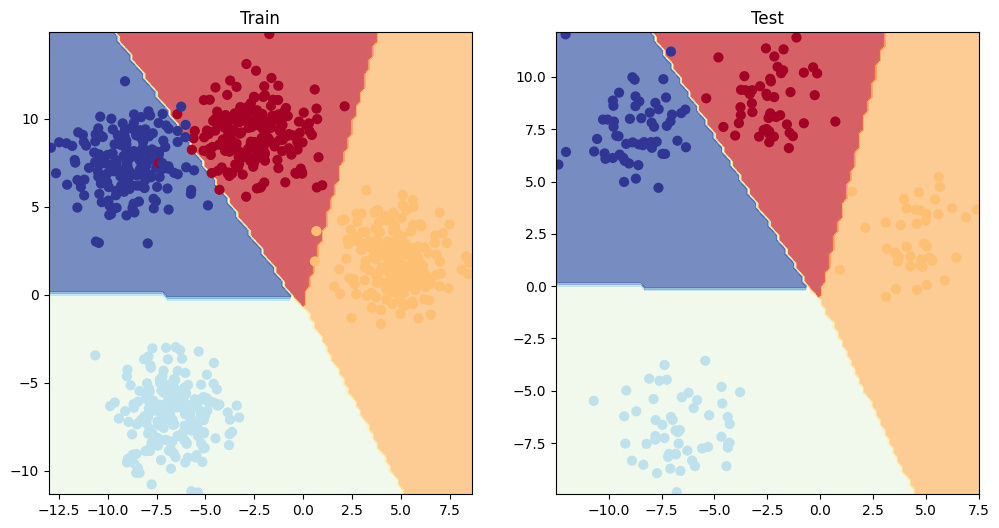

In [589]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [590]:
model_4.to(device)
model_4.eval()

with torch.inference_mode():
    y_logits = model_4(X_blob_test)

y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
y_pred[:200] == y_blob_test[:200]

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, 